In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from gensim.models import Word2Vec
from collections import Counter
import itertools
import logging
logging.basicConfig(format='%(asctime)s:%(levelname)s:%(message)s',level=logging.INFO)
logger = logging.getLogger(__name__)
import seaborn as sns
from sklearn.metrics import accuracy_score,f1_score
import tensorflow.contrib.layers as layers
import os
%matplotlib inline

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Data Preprocessing

In [25]:
data=pd.read_csv('./input/train_set.csv')
test=pd.read_csv('./input/test_set.csv')

#### Char Level

In [58]:
length_char=data['article'].apply(lambda x:len(x.split()))

In [59]:
length_char.describe()

count    102277.000000
mean       1177.100159
std        1348.431565
min          50.000000
25%         497.000000
50%         842.000000
75%        1408.000000
max       55804.000000
Name: article, dtype: float64

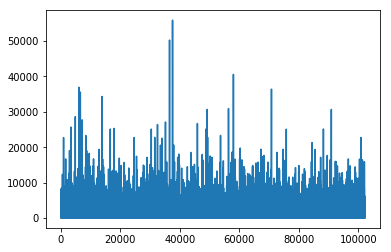

In [60]:
length_char.plot()

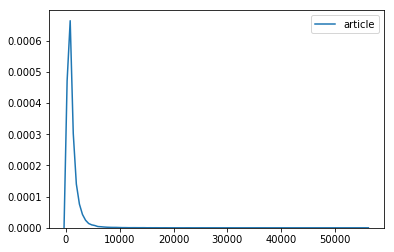

In [61]:
sns.kdeplot(length_char)

#### Word Level

In [62]:
length_word=data.word_seg.apply(lambda x:len(x.split()))

In [63]:
length_word.describe()

count    102277.000000
mean        716.954604
std         801.804540
min           6.000000
25%         305.000000
50%         514.000000
75%         862.000000
max       39759.000000
Name: word_seg, dtype: float64

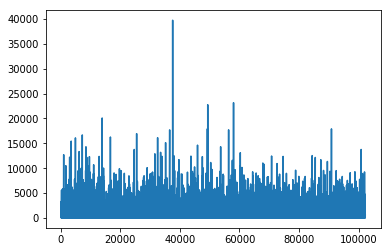

In [64]:
length_word.plot()

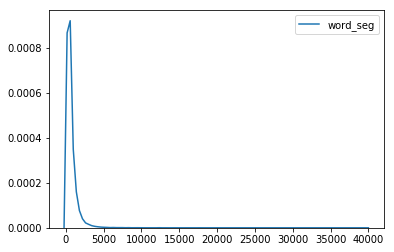

In [65]:
sns.kdeplot(length_word)

#### Split Train and Dev set

In [12]:
data['dev']=0
data['id']=data['id'].astype(np.int32)
def get_dev(row):
    if row['id']%10==0:
        row['dev']=1
    return row
data=data.apply(get_dev,axis=1)

#### Add Labels

In [13]:
def add_labels(row):
    row[row['class']]=1
    return row

In [14]:
labels=data['class'].unique().tolist()

In [15]:
labels.sort()

In [16]:
tmp=pd.DataFrame(columns=labels)
data=pd.concat([data,tmp],axis=1)
data=data.apply(add_labels,axis=1)
data=data.fillna(0)

In [18]:
data.to_csv('./input/train_set.csv',index=False)

### Embedding

In [43]:
data=pd.read_csv('./input/train_set.csv')

In [41]:
def all_char(sentences):
    char_count=dict(Counter(itertools.chain(*sentences)))
    chars=[char for char in char_count.keys()]
    return chars

def pad_sentence(sentence,valid_char,padding_char='PAD',max_length=1500):
    """
    If length of sentence less than max_length,pad it with padding_char.
    Otherwise,save the beginning and ending half max_length of sentence.
    """
    sentence=sentence.split()
    sentence=[x for x in sentence if x in valid_char]
    sen_len=len(sentence)
    if sen_len>max_length:
        sentence=sentence[:int(max_length/2)]+sentence[int(-max_length/2):]
    else:
        sentence+=(max_length-sen_len)*[padding_char]
    return np.array(sentence).reshape([1,max_length])

In [2]:
TOKEN='article'

In [28]:
train_token=pd.concat([data[TOKEN],test[TOKEN]],axis=0,ignore_index=True)

In [ ]:
model=Word2Vec(train_token.apply(lambda x:x.split()).values,
                        size=128,window=10,min_count=20,workers=8,iter=40)

model.save(f'./model/{TOKEN}_128dim_40epoch_model')

In [34]:
#model=Word2Vec.load(f'./model/{TOKEN}_128dim_40epoch_model')
model.init_sims()

2018-08-15 04:06:13,633:INFO:precomputing L2-norms of word weight vectors


In [35]:
valid_char=set(model.wv.vocab.keys())  # use type SET to speed up padding

In [52]:
labels=[]
for i in range(1,20):
    labels.append(str(i))

In [53]:
dev=data.loc[data.dev==1].reset_index(drop=True)
train=data.loc[data.dev!=1].reset_index(drop=True)

train_len=train[TOKEN].apply(lambda x:min(len(x.split()),1500))
dev_len=train[TOKEN].apply(lambda x:min(len(x.split()),1500))

train[TOKEN]=train[TOKEN].apply(lambda x:pad_sentence(x,valid_char))
dev[TOKEN]=dev[TOKEN].apply(lambda x:pad_sentence(x,valid_char))

train_X=np.concatenate(train[TOKEN])
train_y=train[labels].astype(np.float32).as_matrix()
dev_X=np.concatenate(dev[TOKEN])
dev_y=dev[labels].astype(np.float32).as_matrix()

In [54]:
valid_char=list(valid_char)
embedding=np.zeros([len(valid_char)+1,128],dtype=np.float32)

for index,char in enumerate(valid_char):
    embedding[index]=model.wv.word_vec(char,use_norm=True)
    
valid_char+=('PAD',)

In [55]:
np.save(f'./input/{TOKEN}_train_X.npy',train_X)
np.save(f'./input/{TOKEN}_train_y.npy',train_y)
np.save(f'./input/{TOKEN}_dev_X.npy',dev_X)
np.save(f'./input/{TOKEN}_dev_y.npy',dev_y)
np.save(f'./input/{TOKEN}_train_len.npy',train_len)
np.save(f'./input/{TOKEN}_dev_len.npy',dev_len)

In [56]:
np.save(f'./input/{TOKEN}_embedding.npy',embedding)
np.save(f'./input/{TOKEN}_valid_char.npy',valid_char)

## New Beginning

In [3]:
train_X=np.load(f'./input/{TOKEN}_train_X.npy')
train_y=np.load(f'./input/{TOKEN}_train_y.npy')
train_len=np.load(f'./input/{TOKEN}_train_len.npy')
dev_X=np.load(f'./input/{TOKEN}_dev_X.npy')
dev_y=np.load(f'./input/{TOKEN}_dev_y.npy')
dev_len=np.load(f'./input/{TOKEN}_dev_len.npy')
embedding=np.load(f'./input/{TOKEN}_embedding.npy')
valid_char=np.load(f'./input/{TOKEN}_valid_char.npy')
labels=[]
for i in range(1,20):
    labels.append(str(i))

## Algorithms
### Tensorflow version

In [5]:
seed=1
EMBEDDING_DIM=128
MAX_SEQUENCE_LENGTH=1500
L2_REG = 1e-4

### Text CNN

In [3]:
def batch_iter(X,y,batch_size,num_epochs,shuffle=True):
    data_size=len(X)
    num_batches_per_epoch=int((data_size-1)/batch_size)+1
    for epoch in range(num_epochs):
        # shuffle the data at each epoch
        if shuffle:
            shuffle_indices=np.random.permutation(np.arange(data_size))
            X=X[shuffle_indices]
            y=y[shuffle_indices]
        for batch_num in range(num_batches_per_epoch):
            start_index=batch_num*batch_size
            end_index=min((batch_num+1)*batch_size,data_size)
            yield X[start_index:end_index],y[start_index:end_index]

In [33]:
class TextCNN(object):
    """
    A CNN for classification.Uses an embedding layer,followed by a convolutional,max-pooling and softmax layer.
    """
    def __init__(self,sequence_length,num_classes,vocab,embed_mode,filter_sizes,
                    num_filters,embedding_mat=None,embedding_size=None,l2_reg_lambda=0.0):
        # Placeholder for input,output,dropout
        self.input_x=tf.placeholder(tf.string,[None,sequence_length],name='input_x')
        self.input_y=tf.placeholder(tf.float32,[None,num_classes],name='input_y')
        self.dropout_keep_prob=tf.placeholder(tf.float32,name='dropout_keep_prob')
        
        # Keeping track of l2 regularization loss (optional)
        l2_loss=tf.constant(0.0)
        
        # Embedding layer
        with tf.device('/cpu:0'),tf.name_scope('embedding'):
            if embed_mode=='static':
                self.W=tf.constant(embedding_mat,name='static_W',dtype=tf.float32)
            if embed_mode=='dynamic':
                self.W=tf.Variable(embedding_mat,name='dynamic_W',dtype=tf.float32)
            if embed_mode=='raw':
                self.W=tf.Variable(tf.truncated_normal([len(vocab),embedding_size],stddev=1,seed=seed),name='raw_W',dtype=tf.float32)
            mapping_strings=tf.constant(vocab)
            table=tf.contrib.lookup.index_table_from_tensor(mapping=mapping_strings)
            ids=table.lookup(self.input_x)
            tf.tables_initializer().run()
            self.embedded_chars=tf.nn.embedding_lookup(self.W,ids)
            self.embedded_chars_expanded=tf.expand_dims(self.embedded_chars,-1)
            # shape:[batch_size,sequence_length,embedding_size,channel]
            
        # Create a convolution + maxpool layer for each filter size
        pooled_outputs=[]
        for i,filter_size in enumerate(filter_sizes):
            with tf.name_scope('conv-maxpool-%s'%filter_size):
                # Convolution Layer
                filter_shape=[filter_size,embedding_size,1,num_filters]
                W=tf.Variable(tf.truncated_normal(filter_shape,stddev=0.1,seed=seed+i),name='W',dtype=tf.float32)
                b=tf.Variable(tf.truncated_normal([num_filters],stddev=0.1,seed=seed+i),name='b',dtype=tf.float32)
                conv=tf.nn.conv2d(
                    self.embedded_chars_expanded,
                    W,
                    strides=[1,1,1,1],
                    padding='VALID',
                    name='conv')
                # shape:[batch_size,sequence_length-filter_size+1,1,channel(num_filters)]

                # Apply nonlinearity
                h=tf.nn.relu(tf.nn.bias_add(conv,b),name='relu')
                # Maxpooling over the outputs
                pooled=tf.nn.max_pool(
                    h,
                    ksize=[1,sequence_length-filter_size+1,1,1],
                    strides=[1,1,1,1],
                    padding='VALID',
                    name='pool')
                # shape:[batch_size,1,1,channel(num_filters)]

                pooled_outputs.append(pooled)

        # Combine all the pooled features
        num_filters_total=num_filters*len(filter_sizes)
        self.h_pool=tf.concat(pooled_outputs,3)
        # shape:[batch_size,1,1,num_filters_total]

        self.h_pool_flat=tf.reshape(self.h_pool,[-1,num_filters_total])
        # shape:[batch_size,num_filters_total]

        #  Add dropout
        with tf.name_scope('dropout'):
            self.h_drop=tf.nn.dropout(self.h_pool_flat,self.dropout_keep_prob)

        # Final (unnormalized) scores and predictions
        with tf.name_scope('output'):
            W=tf.get_variable(
                'W',
                shape=[num_filters_total,num_classes],
                initializer=tf.contrib.layers.xavier_initializer(seed=seed))
            b=tf.Variable(tf.truncated_normal([num_classes],stddev=0.1,seed=seed+10),name='b',dtype=tf.float32)
            l2_loss+=tf.nn.l2_loss(W)
            l2_loss+=tf.nn.l2_loss(b)
            self.logits=tf.nn.xw_plus_b(self.h_drop,W,b,name='logits')
            self.predictions=tf.argmax(self.logits,1,name='predictions')

        # Calculate mean cross-entropy loss
        with tf.name_scope('loss'):
            losses=tf.nn.softmax_cross_entropy_with_logits(logits=self.logits,labels=self.input_y)
            self.loss=tf.reduce_mean(losses)+l2_reg_lambda*l2_loss
            
        with tf.name_scope('accuracy'):
            correct_predictions=tf.equal(self.predictions,tf.argmax(self.input_y,1))
            self.accuracy = tf.reduce_mean(tf.cast(correct_predictions, "float"), name="accuracy")

In [ ]:
def train_model(train_X,train_y,dev_X,dev_y,batch_size,epoch):
    with tf.Graph().as_default():
        #gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=1)
        #sess=tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
        #config=tf.ConfigProto(device_count={'gpu':1,'cpu':8},
                #inter_op_parallelism_threads = 4,   
                #intra_op_parallelism_threads = 4,
                #gpu_options=gpu_options
                #)
        sess=tf.Session()
        with sess.as_default():
            #saver.restore(sess,'/runs/model.ckpt')
            
            cnn=TextCNN(
                sequence_length=1500,
                num_classes=len(labels),
                vocab=valid_char,
                embedding_mat=embedding,
                embedding_size=128,
                embed_mode='dynamic',
                l2_reg_lambda=0.,
                filter_sizes=[2,3,4,5,7],
                num_filters=128,
            )
            optimizer=tf.train.AdamOptimizer()
            global_step=tf.Variable(0,name='global_step',trainable=False)
            grads_and_vars=optimizer.compute_gradients(cnn.loss)
            train_op=optimizer.apply_gradients(grads_and_vars,global_step=global_step)
            
            # Output directory for models and summaries
            #timestamp=str(int(time.time()))
            out_dir=os.path.abspath(os.path.join(os.path.curdir,'runs'))
            print('Writing to {}\n'.format(out_dir))
            
            # Summaries for loss and accuracy
            loss_summary=tf.summary.scalar('loss',cnn.loss)
            accuracy_summary=tf.summary.scalar('accuracy',cnn.accuracy)
            
            # train summaries
            train_summary_op=tf.summary.merge([loss_summary,accuracy_summary])
            train_summary_dir=os.path.join(out_dir,'summaries','train')
            train_summary_writer=tf.summary.FileWriter(train_summary_dir,sess.graph)
            
            # dev summaries
            dev_summary_op=tf.summary.merge([loss_summary,accuracy_summary])
            dev_summary_dir=os.path.join(out_dir,'summaries','dev')
            dev_summary_writer=tf.summary.FileWriter(dev_summary_dir,sess.graph)
            
            # Checkpoint directory.Tensorflow assume this directory already exists so we need to create it
            checkpoint_dir=os.path.abspath(os.path.join(out_dir,'checkpoints'))
            checkpoint_prefix=os.path.join(checkpoint_dir,'model')
            if not os.path.exists(checkpoint_dir):
                os.makedirs(checkpoint_dir)
            saver=tf.train.Saver(tf.global_variables(),max_to_keep=1)
                       
            # initialize all variables
            sess.run(tf.global_variables_initializer())
            
            def train_step(x_batch,y_batch):
                feed_dict={
                    cnn.input_x:x_batch,
                    cnn.input_y:y_batch,
                    cnn.dropout_keep_prob:0.5
                }
                _,step,summaries,loss=sess.run(
                    [train_op,global_step,train_summary_op,cnn.loss],feed_dict)
                #logger.info("{}:step{},loss {:g}".format(time_str,step,loss))
                train_summary_writer.add_summary(summaries,step)
                
            def dev_step(x_batch,y_batch):
                feed_dict={
                    cnn.input_x:x_batch,
                    cnn.input_y:y_batch,
                    cnn.dropout_keep_prob:1.0
                }
                step,loss,y_pred,y_true,summaries=sess.run(
                    [global_step,cnn.loss,cnn.predictions,cnn.input_y,dev_summary_op],feed_dict)
                #logger.info("step{},loss {:g}".format(step,loss))
                dev_summary_writer.add_summary(summaries,step)
                return y_pred,y_true
        
        # Generate batches
        batches=batch_iter(
            train_X,train_y,batch_size,epoch,shuffle=True)
        num_batches_per_epoch=int((len(train_X)-1)/batch_size)+1
        num_epoch=0
        for (x_batch,y_batch) in batches:
            train_step(x_batch,y_batch)
            current_step=tf.train.global_step(sess,global_step)
            #saver.save(sess,checkpoint_prefix,global_step=current_step)
            if current_step%num_batches_per_epoch==0:
                num_epoch+=1
                dev_batches=batch_iter(dev_X,dev_y,64,1,False)
                pred=[]
                true=[]
                for (x_bat,y_bat) in dev_batches:
                    y_pred,y_true=dev_step(x_bat,y_bat)
                    pred+=y_pred.tolist()
                    true+=y_true.tolist()
                score=accuracy_score(pred,ture)
                logger.info("{}epoch:accuracy:{}".format(num_epoch,score))

In [ ]:
train_model(train_X,train_y,dev_X,dev_y,64,50)

## BiGRU+Attention

In [6]:
def batch_iter_rnn(X,y,length,batch_size,num_epochs,shuffle=True):
    data_size=len(X)
    num_batches_per_epoch=int((data_size-1)/batch_size)+1
    for epoch in range(num_epochs):
        # shuffle the data at each epoch
        if shuffle:
            shuffle_indices=np.random.permutation(np.arange(data_size))
            X=X[shuffle_indices]
            y=y[shuffle_indices]
            length=length[shuffle_indices]
        for batch_num in range(num_batches_per_epoch):
            start_index=batch_num*batch_size
            end_index=min((batch_num+1)*batch_size,data_size)
            yield X[start_index:end_index],y[start_index:end_index],length[start_index:end_index]

In [7]:
class TextRNN(object):
    def __init__(self,max_length,num_classes,vocab,embed_mode,hidden_units=256,
                    embedding_mat=None,embedding_size=None,l2_reg_lambda=0.0):
        # Placeholder for input,output,dropout
        self.input_x=tf.placeholder(tf.int32,[None,max_length],name='input_x')
        self.input_y=tf.placeholder(tf.float32,[None,num_classes],name='input_y')
        self.dropout_keep_prob=tf.placeholder(tf.float32,shape=[],name='dropout_keep_prob')
        self.batch_size=tf.placeholder(tf.int32,shape=[],name='batch_size')
        self.sequence_length=tf.placeholder(tf.int32,shape=[None],name='sequence_length')
        
        # Keeping track of l2 regularization loss (optional)
        l2_loss=tf.constant(0.0)
        
        # Embedding layer
        with tf.device('/cpu:0'),tf.name_scope('embedding'):
            if embed_mode=='static':
                self.W=tf.constant(embedding_mat,name='static_W',dtype=tf.float32)
            if embed_mode=='dynamic':
                self.W=tf.Variable(embedding_mat,name='dynamic_W',dtype=tf.float32)
            if embed_mode=='raw':
                self.W=tf.Variable(tf.truncated_normal([len(vocab),embedding_size],stddev=0.1),name='raw_W',dtype=tf.float32)
            #mapping_strings=tf.constant(vocab)
            #table=tf.contrib.lookup.index_table_from_tensor(mapping=mapping_strings)
            #ids=table.lookup(self.input_x)
            #tf.tables_initializer().run()
            self.embedded_chars=tf.nn.embedding_lookup(self.W,self.input_x)
            #self.embedded_chars_expanded=tf.expand_dims(self.embedded_chars,-1)
            # size:[batch_size,sequence_length,embedding_size,channel]
            
        # Create a convolution + maxpool layer for each filter size
        with tf.name_scope('rnn'):
            gru_fw_cell=tf.contrib.rnn.GRUCell(hidden_units) #forward direction cell
            gru_bw_cell=tf.contrib.rnn.GRUCell(hidden_units) #backward direction cell
            gru_fw_cell=tf.contrib.rnn.DropoutWrapper(gru_fw_cell,output_keep_prob=self.dropout_keep_prob)
            gru_bw_cell=tf.contrib.rnn.DropoutWrapper(gru_bw_cell,output_keep_prob=self.dropout_keep_prob)
            initial_state_fw=gru_fw_cell.zero_state(self.batch_size,dtype=tf.float32)
            initial_state_bw=gru_bw_cell.zero_state(self.batch_size,dtype=tf.float32)
            outputs,state=tf.nn.bidirectional_dynamic_rnn(gru_fw_cell,gru_bw_cell,self.embedded_chars,
                            initial_state_fw=initial_state_fw,initial_state_bw=initial_state_bw,
                            sequence_length=self.sequence_length,dtype=tf.float32)
            # outputs size:[batch_size,max_time,hidden_units]*2
            # state size:[batch_size,hidden_units]*2
            
            outputs=tf.concat(outputs,axis=2)
            # size:[batch_size,max_time,hidden_units*2]
            
            atten=self.attention(outputs,hidden_units*2)
            # size:[batch_size,hidden_units*2]
            
            state=tf.concat(state,axis=1)
            # size:[batch_size,hidden_units*2]
            
            final=tf.concat([atten,state],axis=1)
            # size:[batch_size,hidden_units*4]
            
        with tf.name_scope("dense"):
            dense=tf.layers.dense(final,hidden_units*2,activation=tf.tanh)
            last_dropout=tf.nn.dropout(dense,self.dropout_keep_prob)
            # size:[batch_size,hidden_units*2]

        
        # Final (unnormalized) scores and predictions
        with tf.name_scope('output'):
            W=tf.get_variable(
                'W',
                shape=[hidden_units*2,num_classes],
                initializer=tf.contrib.layers.xavier_initializer())
            b=tf.Variable(tf.constant(0.1,shape=[num_classes]),name='b')
            l2_loss+=tf.nn.l2_loss(W)
            l2_loss+=tf.nn.l2_loss(b)
            self.logits=tf.nn.xw_plus_b(last_dropout,W,b,name='logits')
            self.predictions=tf.argmax(self.logits,1,name='predictions')

        # Calculate mean cross-entropy loss
        with tf.name_scope('loss'):
            losses=tf.nn.softmax_cross_entropy_with_logits(logits=self.logits,labels=self.input_y)
            self.loss=tf.reduce_mean(losses)+l2_reg_lambda*l2_loss
            
        with tf.name_scope('accuracy'):
            correct_predictions=tf.equal(self.predictions,tf.argmax(self.input_y,1))
            self.accuracy = tf.reduce_mean(tf.cast(correct_predictions, "float"), name="accuracy")
    
    def attention(self, inputs, size, scope=None):
        with tf.variable_scope(scope or 'attention') as scope:
          # correspond to Uw in the paper
          attention_context_vector = tf.get_variable(name='attention_context_vector',
                                                     shape=[size],
                                                     regularizer=layers.l2_regularizer(scale=L2_REG),
                                                     dtype=tf.float32)
          # correspond to Uit in the paper
          input_projection = layers.fully_connected(inputs, size,
                                                    activation_fn=tf.tanh,
                                                    weights_regularizer=layers.l2_regularizer(scale=L2_REG))
          # size:[batch_size*document_size,sentence_size,size]
        
          vector_attn = tf.reduce_sum(tf.multiply(input_projection, attention_context_vector), axis=2, keep_dims=True)
          # size:[batch_size*document_size,sentence_size,1]
    
          attention_weights = tf.nn.softmax(vector_attn, dim=1)
          # size:[batch_size*document_size,sentence_size,1]
          
          weighted_projection = tf.multiply(inputs, attention_weights)
          # size:[batch_size*document_size,sentence_size,size]
          
          # correspond to Si in the paper
          outputs = tf.reduce_sum(weighted_projection, axis=1)
          # size:[batch_size*document_size,size]

        return outputs

In [8]:
def train_model_rnn(train_x,train_y,train_len,dev_x,dev_y,dev_len,batch_size,epoch):
    with tf.Graph().as_default():
        gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.5)
        sess=tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
        with sess.as_default():
            #saver.restore(sess,'/runs/model.ckpt')
            rnn=TextRNN(
                max_length=MAX_SEQUENCE_LENGTH,
                num_classes=len(labels),
                vocab=valid_char,
                embedding_mat=embedding,
                embedding_size=128,
                embed_mode='dynamic',
                l2_reg_lambda=0.0,
                hidden_units=256
            )
            #optimizer=tf.trian.AdagradOptimizer(0.001)
            optimizer=tf.train.AdamOptimizer()
            global_step=tf.Variable(0,name='global_step',trainable=False)
            grads_and_vars=optimizer.compute_gradients(rnn.loss)
            train_op=optimizer.apply_gradients(grads_and_vars,global_step=global_step)
            
            # Output directory for models and summaries
            #timestamp=str(int(time.time()))
            out_dir=os.path.abspath(os.path.join(os.path.curdir,'runs','biGRU'))
            print('Writing to {}\n'.format(out_dir))
            
            # Summaries for loss and accuracy
            loss_summary=tf.summary.scalar('loss',rnn.loss)
            accuracy_summary=tf.summary.scalar('accuracy',rnn.accuracy)
            
            # train summaries
            train_summary_op=tf.summary.merge([loss_summary,accuracy_summary])
            train_summary_dir=os.path.join(out_dir,'summaries','train')
            train_summary_writer=tf.summary.FileWriter(train_summary_dir,sess.graph)
            
            # dev summaries
            dev_summary_op=tf.summary.merge([loss_summary,accuracy_summary])
            dev_summary_dir=os.path.join(out_dir,'summaries','dev')
            dev_summary_writer=tf.summary.FileWriter(dev_summary_dir,sess.graph)
            
            # Checkpoint directory.Tensorflow assume this directory already exists so we need to create it
            checkpoint_dir=os.path.abspath(os.path.join(out_dir,'checkpoints'))
            checkpoint_prefix=os.path.join(checkpoint_dir,'model')
            if not os.path.exists(checkpoint_dir):
                os.makedirs(checkpoint_dir)
            saver=tf.train.Saver(tf.global_variables(),max_to_keep=1)
            #saver.restore(sess,'/home/cuikeyu/junting_chen/NLP/runs/att_bi_rnn_chinese/checkpoints/model')           
            # initialize all variables
            sess.run(tf.global_variables_initializer())
            
            def train_step(x_batch,y_batch,length):
                feed_dict={
                    rnn.input_x:x_batch,
                    rnn.input_y:y_batch,
                    rnn.dropout_keep_prob:0.9,
                    rnn.batch_size:len(x_batch),
                    rnn.sequence_length:length
                }
                _,step,summaries,loss=sess.run(
                    [train_op,global_step,train_summary_op,rnn.loss],feed_dict)
                train_summary_writer.add_summary(summaries,step)
                
            def dev_step(x_batch,y_batch,length):
                feed_dict={
                    rnn.input_x:x_batch,
                    rnn.input_y:y_batch,
                    rnn.dropout_keep_prob:1.0,
                    rnn.batch_size:len(x_batch),
                    rnn.sequence_length:length
                }
                step,summaries,loss,y_pred,y_true=sess.run(
                    [global_step,dev_summary_op,rnn.loss,rnn.predictions,rnn.input_y],feed_dict)
                dev_summary_writer.add_summary(summaries,step)
                return y_pred,y_true
            
            # Generate batches
            batches=batch_iter_rnn(
                train_x,train_y,train_len,batch_size,epoch,shuffle=True)
            num_batches_per_epoch=int((len(train_x)-1)/batch_size)+1
            num_epoch=0
            for (x_batch,y_batch,train_length) in batches:
                train_step(x_batch,y_batch,train_length)
                current_step=tf.train.global_step(sess,global_step)
                #saver.save(sess,checkpoint_prefix,global_step=current_step)
                if current_step%num_batches_per_epoch==0:
                    num_epoch+=1
                    dev_batches=batch_iter_rnn(dev_X,dev_y,dev_len,64,1,False)
                    pred=[]
                    true=[]
                    for (x_bat,y_bat,len_bat) in dev_batches:
                        y_pred,y_true=dev_step(x_bat,y_bat,len_bat)
                        pred+=y_pred.tolist()
                        true+=y_true.tolist()
                    acc=accuracy_score(pred,ture)
                    f1=f1_score(true,pred,average='weighted')
                    logger.info("{}epoch:accuracy:{} f1:{}".format(num_epoch,acc,f1))

In [ ]:
train_model_rnn(train_X,train_y,train_len,dev_X,dev_y,dev_len,64,40)

Instructions for updating:
seq_dim is deprecated, use seq_axis instead


2018-08-15 12:48:53,765:WARNING:From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/rnn.py:417: calling reverse_sequence (from tensorflow.python.ops.array_ops) with seq_dim is deprecated and will be removed in a future version.
Instructions for updating:
seq_dim is deprecated, use seq_axis instead


Instructions for updating:
batch_dim is deprecated, use batch_axis instead


2018-08-15 12:48:53,796:WARNING:From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py:432: calling reverse_sequence (from tensorflow.python.ops.array_ops) with batch_dim is deprecated and will be removed in a future version.
Instructions for updating:
batch_dim is deprecated, use batch_axis instead


Instructions for updating:
keep_dims is deprecated, use keepdims instead


2018-08-15 12:48:54,046:WARNING:From <ipython-input-7-f565aa48db36>:96: calling reduce_sum (from tensorflow.python.ops.math_ops) with keep_dims is deprecated and will be removed in a future version.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


Instructions for updating:
dim is deprecated, use axis instead


2018-08-15 12:48:54,184:WARNING:From <ipython-input-7-f565aa48db36>:99: calling softmax (from tensorflow.python.ops.nn_ops) with dim is deprecated and will be removed in a future version.
Instructions for updating:
dim is deprecated, use axis instead


Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



2018-08-15 12:48:54,296:WARNING:From <ipython-input-7-f565aa48db36>:76: softmax_cross_entropy_with_logits (from tensorflow.python.ops.nn_ops) is deprecated and will be removed in a future version.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



Writing to /home/ubuntu/disk/chen/runs/biGRU



### Keras version

In [3]:
import keras
import tensorflow as tf
from keras import regularizers
from keras.models import Model
from keras.layers import Input,Dense,Embedding,Conv1D,MaxPooling1D,Flatten,GlobalMaxPool1D,Dropout,GlobalAveragePooling1D
from keras.layers import BatchNormalization,ReLU
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import keras.backend.tensorflow_backend as KTF

In [4]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.5)
sess=tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
KTF.set_session(sess)

In [7]:
token2index={}
for index,token in enumerate(valid_char):
    token2index[token]=index

In [8]:
def map_func(token,maps):
    """Map token into index"""
    return maps[token]
v_map_func=np.vectorize(map_func)
train_X=v_map_func(train_X,token2index)
dev_X=v_map_func(dev_X,token2index)

In [5]:
EMBEDDING_DIM=128
MAX_SEQUENCE_LENGTH=1500
NUM_FILTER=64
filter_size=[2,3,4,5]
NUM_CLASS=len(labels)

In [18]:
def text_cnn_model(filter_size,num_filter,vocab,embedding_matrix,embedding_dim,max_seq_len):    
    sequence_input=Input(shape=(max_seq_len,),dtype='int32')
    embedding_layer=Embedding(len(vocab),
                             embedding_dim,
                             weights=[embedding_matrix],
                             input_length=max_seq_len,
                             trainable=False)
    embedded_sequences=embedding_layer(sequence_input)
    outputs=[]
    for index,size in enumerate(filter_size):
        x=Conv1D(num_filter,size,activation='relu',name='conv_{}'.format(index))(embedded_sequences)
        x=GlobalAveragePooling1D()(x)
        outputs.append(x)
    output=keras.layers.concatenate(outputs)
    x=Dense(1024,activation='relu')(output)
    x=Dropout(0.5)(x)
    x=Dense(1024,activation='relu')(x)
    x=Dropout(0.5)(x)
    predictions=Dense(NUM_CLASS,activation='softmax')(x)
    model=Model(sequence_input,predictions)
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                 metrics=['acc'])
    return model

In [10]:
def char_cnn_model(vocab,embedding_matrix,embedding_dim,max_seq_len):    
    conv_layers=[
            [256,7,3],
            [256,7,3],
            [256,3,None],
            [256,3,None],
            [256,3,None],
            [256,3,3]
        ]
    sequence_input=Input(shape=(max_seq_len,),dtype='int32')
    embedding_layer=Embedding(len(vocab),
                             embedding_dim,
                             weights=[embedding_matrix],
                             input_length=max_seq_len,
                             trainable=False)
    x=embedding_layer(sequence_input)
    
    for index,cl in enumerate(conv_layers):
        with tf.name_scope('Conv_layer_{}'.format(index)):
            x=Conv1D(cl[0],cl[1])(x)
        if not cl[-1] is None:
            with tf.name_scope('Maxpool_layer_{}'.format(index)):
                x=MaxPooling1D(cl[-1])(x)
    x=Flatten()(x)
    x=BatchNormalization()(x)
    x=Dense(1024,kernel_regularizer=regularizers.l2(1e-5))(x)
    x=BatchNormalization()(x)
    x=ReLU()(x)
    x=Dropout(0.5)(x)
    x=Dense(1024,kernel_regularizer=regularizers.l2(1e-5))(x)
    x=BatchNormalization()(x)
    x=ReLU()(x)
    x=Dropout(0.5)(x)
    predictions=Dense(NUM_CLASS,activation='softmax')(x)
    model=Model(sequence_input,predictions)
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                 metrics=['acc'])
    return model

In [19]:
cnn=text_cnn_model(filter_size,NUM_FILTER,valid_char,embedding,EMBEDDING_DIM,MAX_SEQUENCE_LENGTH)

In [ ]:
cnn.fit(train_X,train_y,batch_size=512,epochs=40,validation_data=[dev_X,dev_y])